# Intro
Exploratory notebook related to Autoencoders. Includes toy examples implementation and testing of related techniques or subjects.

## Autoencoder
The goal of an autoencoder is to learn a compressed and distributed representation of a dataset. In the most general case this is equivalent to the ability to reconstruct the original input. Also this operation can be seen as an automated feature extraction technique.

For a single-layer feedforward net this can be achieved by using an hidden size smaller than the input one, and training on a function that consider how well the net is then able to reconstruct the input data. If hidden size is equal or higher than input size, the net should learn the identity matrix.

Additional concepts:
* sparsity and regularization
* Denoising Autoencoders (DAE)
* Variational Autoencoder

In [6]:
import time
import numpy as np
import pdb
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Activation, Dense
from keras import backend as K
from keras import optimizers

sns.set_style("dark")
sns.set_context("paper")

%matplotlib notebook

# Numbers Encoding (Keras)
An autoencoder that tries to learn a compressed (?binary) representation for one-hot encoded numbers.
    
1 = 00001  
2 = 00010  
3 = 00100  
4 = 01000  
5 = 10000  

In [ ]:
# create one-hot encoded numbers
input_dim = 10
nums = np.eye(input_dim)[np.arange(input_dim)]
nums

In [ ]:
# model parameters
hidden_size = input_dim//2

# Keras model
model = Sequential()
model.add(Dense(hidden_size, input_dim=input_dim, activation=K.sigmoid))
model.add(Dense(input_size, activation=K.sigmoid))
          
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit model
model.fit(nums, nums, epochs=1000)

In [ ]:
model.summary()
layer_name = 'dense_9'

In [ ]:
# hidden layer weights
sns.heatmap(model.get_layer(layer_name).get_weights()[0])
sns.plt.show()

In [ ]:
# get hidden layer output building "intermediate model"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(nums)

In [ ]:
intermediate_output

In [ ]:
# predictions
sns.heatmap(model.predict(nums[np.array([1,2,3,5,6])]))
sns.plt.show()

# MNIST (Keras)
Train autoencoder on the MNIST dataset.

In [1]:
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
# get only subset of images
num_images = 1000
X_train = X_train[:num_images].reshape(num_images, num_pixels).astype('float32')
X_test = X_test[:num_images].reshape(num_images, num_pixels).astype('float32')

In [4]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [7]:
# Keras model
model = Sequential()
model.add(Dense(512, input_dim=num_pixels, activation=K.relu))
model.add(Dense(256, activation=K.relu))
model.add(Dense(512, activation=K.relu))
model.add(Dense(num_pixels, activation=K.relu))
          
# compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               402192    
Total params: 1,067,024
Trainable params: 1,067,024
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(X_train, X_train, batch_size=100, epochs=10)

Epoch 1/10
1000/1000 [==============================] - 0s - loss: 0.0145 - acc: 0.0130     
Epoch 2/10
1000/1000 [==============================] - 0s - loss: 0.0138 - acc: 0.0110     
Epoch 3/10
1000/1000 [==============================] - 0s - loss: 0.0133 - acc: 0.0130     

<IPython.core.display.Javascript object>


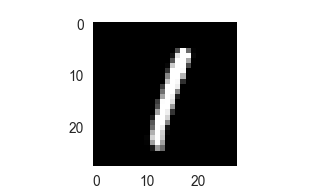

In [11]:
# show original test example
sns.plt.imshow(X_test[5].reshape(28, 28), cmap='gray')

<IPython.core.display.Javascript object>


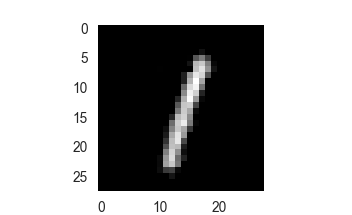

In [23]:
# show predicted results
pred = model.predict(X_test[5].reshape(1, num_pixels))
plt.imshow(pred.reshape(28, 28), cmap='gray')

<IPython.core.display.Javascript object>


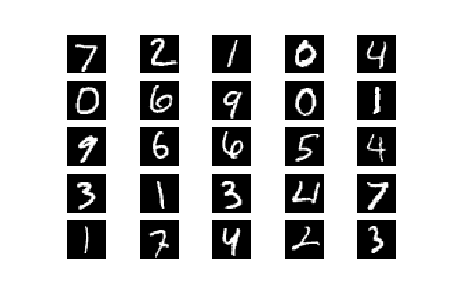

In [24]:
# show several original test examples
plot_side = 5
f, axarr = plt.subplots(plot_side, plot_side)
for row in range(plot_side):
    for col in range(plot_side):
        axarr[row, col].imshow(X_test[10*row+col].reshape(28, 28), cmap='gray')
        axarr[row, col].set_title('')
        axarr[row, col].axis('off')

<IPython.core.display.Javascript object>


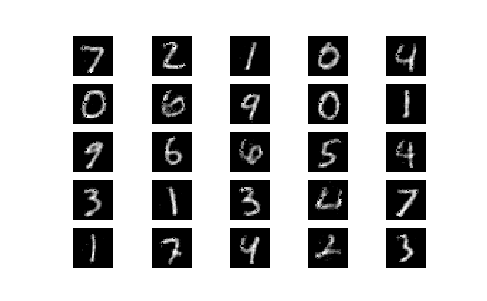

In [25]:
# show predicted results
plot_side = 5
f, axarr = plt.subplots(plot_side, plot_side)
for row in range(plot_side):
    for col in range(plot_side):
        pred = model.predict(X_test[10*row+col].reshape(1, num_pixels))
        axarr[row, col].imshow(pred.reshape(28, 28), cmap='gray')
        axarr[row, col].set_title('')
        axarr[row, col].axis('off')